Using Bayesian inference for learning synthesis-structure-property relationship via coregionalized piecewise function determination.
Examples for paper:
Code and examples are presented for 1D algorithms.

The code currently demonstrated the use of the included (older version) hermes library, downloaded below. The standalone SAGE library is also included in the download. The SAGE function calls are the same as Hermes.

For example, you can replace `from hermes.joint import SAGE_1D` with `from sage.joint import SAGE_1D`.

Table of Content:
* Libraries to Install
* Import Libraries
* 1D Case:
    * .py file for 1D functions.
    * 1D Edge Case Challenges
         * Set up challenge data
         * Run algorithms (1 core scripts) and collect data
         * Visualize results
         * Compute performance measures available in paper Table 1.

### Libraries to Install: ** please see requirements.txt and SAGEn_241025a.yml **

### Import Libraries

In [ ]:
from sage_1D_functions_230804a import *
import hermes
import sage
from hermes.joint import SAGE_1D

import matplotlib.pyplot as plt

import numpyro
import numpy as np
from numpy.random import default_rng

import torch

import dill
from torch.distributions import constraints

from torch.nn import Parameter
from torch.nn import Softmax
from torch.nn.functional import one_hot

import pyro
from pyro.infer import MCMC, NUTS, HMC, Predictive, SVI, Trace_ELBO
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer.autoguide import initialization as init

from scipy.spatial.distance import pdist, squareform
from scipy.spatial import Voronoi
from scipy.stats import multivariate_normal, entropy
import scipy.io as sio
from scipy.special import softmax as softnp
from scipy.stats.mstats import mquantiles
from scipy.interpolate import griddata
from scipy.stats import gamma, gennorm

import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)
from jax.lax import dynamic_slice
from jax.nn import one_hot as jax_one_hot

from numpyro.infer import MCMC as nMCMC
from numpyro.infer import NUTS as nNUTS
from numpyro.infer import Predictive as nPredictive
import numpyro.distributions as ndist

import tensorflow_probability as tfp

from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics.cluster import fowlkes_mallows_score as fmi
from sklearn.metrics import fowlkes_mallows_score as fms

torch.set_default_dtype(torch.float64)
from tqdm import trange

from applied_active_learning_191228a import *
from cameo_240821a import *

## 1-dimensional Cases

### 1D Edge Case Challenges.

#### Set up 1D Challenges data
- Challenge 1: Structure data is more informative of phase boundaries.
- Challenge 2: Functional property is more informative of phase boundaries.

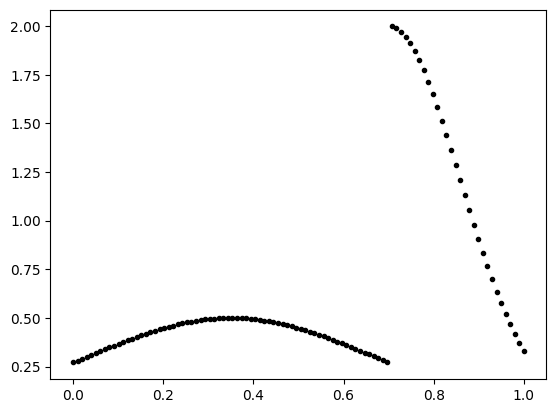

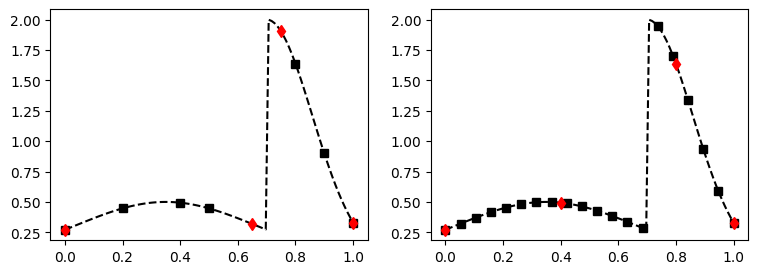

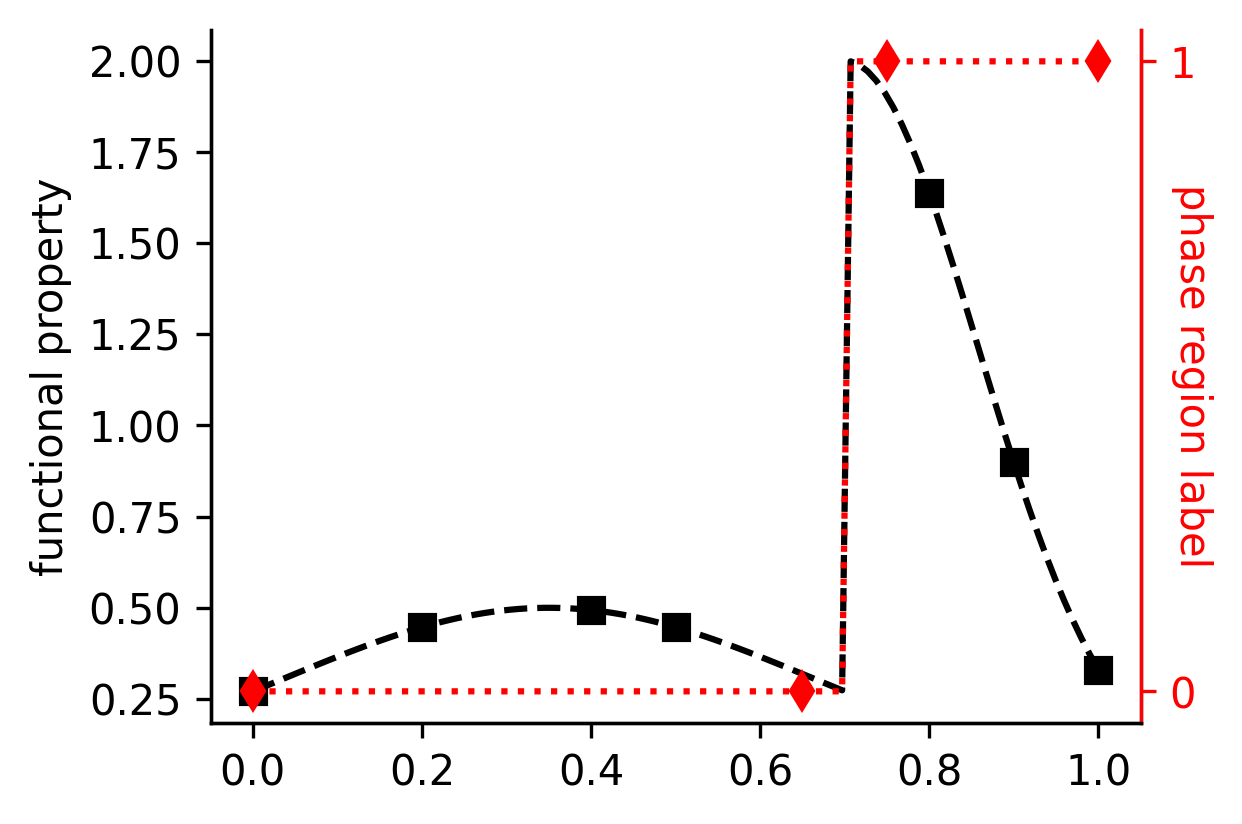

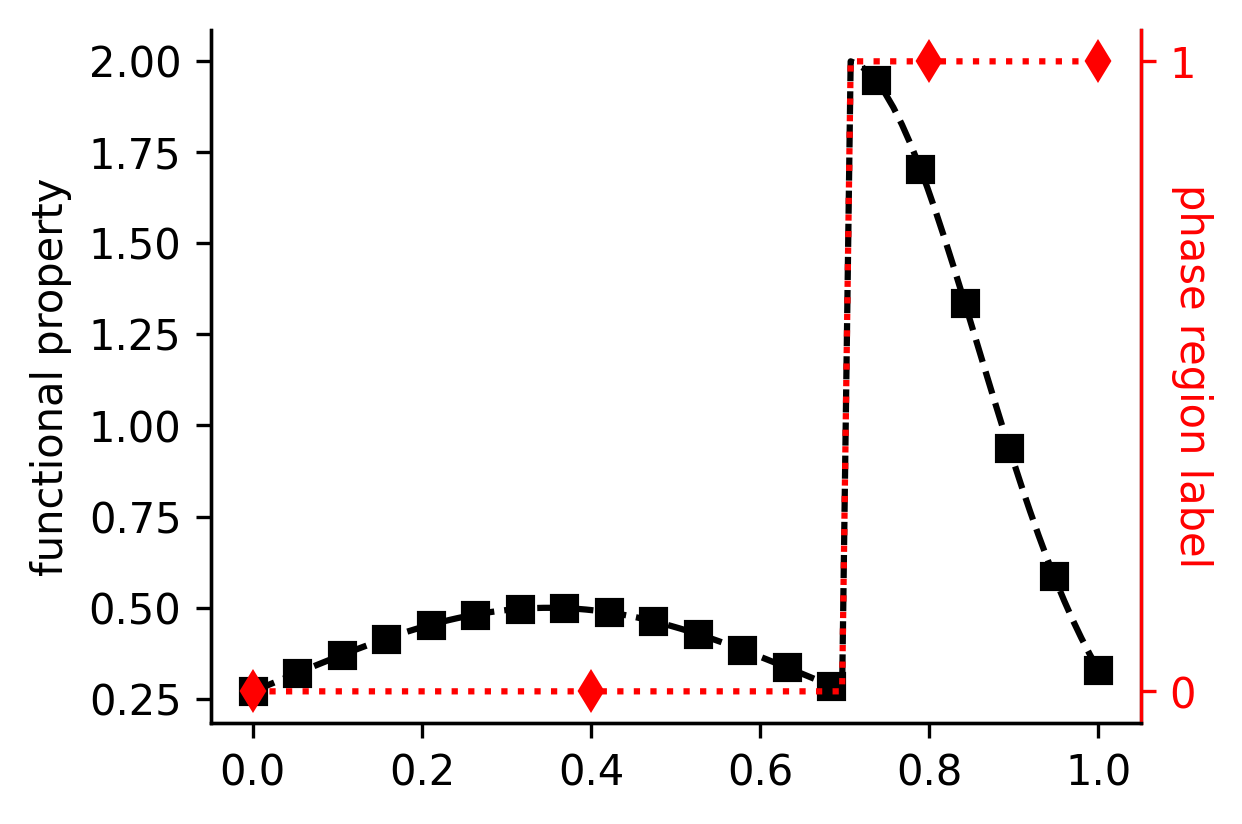

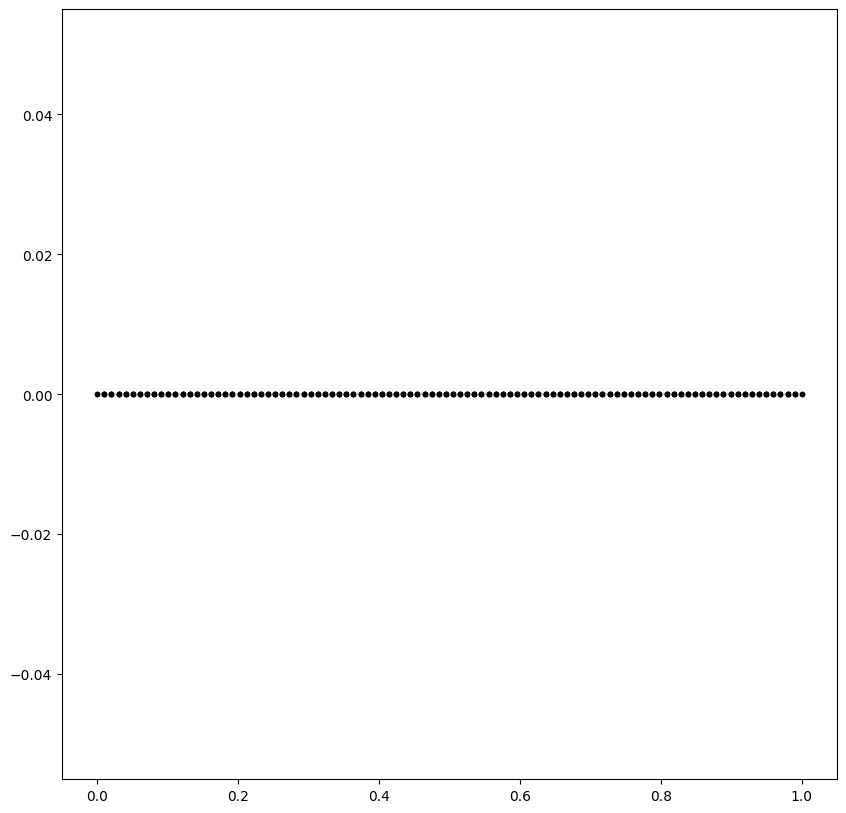

In [ ]:
x = np.linspace(0,1,100)

y = simple_challenge_1D_2regions(x)
plt.figure()
plt.plot(x,y,'k.')

# Actual X values
xx = np.linspace(0,1,100)
xst1 = np.asarray([0., 0.65, 0.75, 1.])[:,None]
xfp1 = np.asarray([0.,.2, .4, .5, .8, .9, 1.])[:,None]

xst2 = np.asarray([0., .4, .8, 1.])[:,None]
xfp2 = np.linspace(0,1,20)[:,None]

yyst = xx > 0.7
yst1 = xst1 > 0.7
yfp1 = simple_challenge_1D_2regions(xfp1)
yst2 = xst2 > 0.7
yfp2 = simple_challenge_1D_2regions(xfp2)

plt.figure(figsize = (9,3))
plt.subplot(1,2,1)
plt.plot(x, y, 'k--')
plt.plot(xfp1, yfp1, 'ks')
plt.plot(xst1, simple_challenge_1D_2regions(xst1), 'rd')
plt.subplot(1,2,2)
plt.plot(x, y, 'k--')
plt.plot(xfp2, yfp2, 'ks')
plt.plot(xst2, simple_challenge_1D_2regions(xst2), 'rd')

fig = plt.figure(figsize = (4,3), dpi=300)
ax11 = fig.add_subplot()
ax11.plot(x, y, 'k--')
plt.plot(xfp1, yfp1, 'ks')
ax11.spines['top'].set_visible(False)
ax11.set_ylabel('functional property')
ax12 = ax11.twinx()
ax12.plot(xx, yyst, 'r:')
ax12.plot(xst1, yst1, 'rd')
ax12.set_yticks([0,1])
ax12.spines['right'].set_color('red')
ax12.tick_params(axis='y', colors='red')
ax12.spines['top'].set_visible(False)
ax12.set_ylabel('phase region label', rotation = 270, color = 'red')

fig = plt.figure(figsize = (4,3), dpi=300)
ax21 = fig.add_subplot()
ax21.plot(x, y, 'k--')
plt.plot(xfp2, yfp2, 'ks')
ax21.spines['top'].set_visible(False)
ax21.set_ylabel('functional property')
ax22 = ax21.twinx()
ax22.plot(xx, yyst, 'r:')
ax22.plot(xst2, yst2, 'rd')
ax22.set_yticks([0,1])
ax22.spines['right'].set_color('red')
ax22.tick_params(axis='y', colors='red')
ax22.spines['top'].set_visible(False)
ax22.set_ylabel('phase region label', rotation = 270, color = 'red')

N = x.shape[0]
XY = np.concatenate((x[:,None],np.zeros((N,1))),axis=1)
S = np.diag(np.ones(N-1),-1) + np.diag(np.ones(N-1),1)
plt.figure(figsize = (10,10))
plot_graph(S, XY)

#### Hermes example

In [ ]:
with open(r"data_1D_challenges.dill", "rb") as input_file:
    [xst1, yst1, xfp1, yfp1,
    xst2, yst2, xfp2, yfp2] = dill.load(input_file)

Xpred = np.linspace(0,1,100)[:,None]
sage_1d = SAGE_1D(
    num_phase_regions=2,
    num_samples=100,
    num_warmup=10,
    target_accept_prob = 0.8,
    max_tree_depth = 5,
    jitter = 1E-6,
    locations_structure = xst1,
    locations_functional_property = xfp1,
    locations_prediction = Xpred,
    target_structure_labels = yst1,
    target_functional_properties = yfp1,
    gpr_variance_bounds = np.asarray([.01, 2.]),
    gpr_lengthscale_bounds = np.asarray([.2,1.]),
    gpr_noise_bounds= np.asarray([0.001,.01]),
    change_point_bounds = np.asarray([0.5, 1.]),
    gpr_bias_bounds = np.asarray([-2., 2.]),
    )

sage_1d.run()
predictions_1d_1 = sage_1d.predictions

In [ ]:
with open(r"data_1D_challenges_full.dill", "rb") as input_file:  # !!!!!!! CHANGE ME !!!!!!!!!!!
    [xfull, ysfull, yffull] = dill.load(input_file)

# phase_region_labels_mean
# phase_region_labels_std
# change_point_mean
# change_point_std
# max_likelihood_change_points
gpr_mean = predictions_1d_1['functional_property_mean']
gpr_std = predictions_1d_1['functional_property_std']
cp_samples = predictions_1d_1['change_point_samples']
mllk_gpr_mean = predictions_1d_1['max_likelihood_functional_property_noiseless_mean']
mllk_gpr_var = predictions_1d_1['max_likelihood_functional_property_noiseless_var']

fig = plt.figure(figsize = (4,3))

ax11 = fig.add_subplot()
ax11.plot(xfull, yffull, 'k--')
ax11.plot(xfp1, yfp1, 'ks')
ax11.spines['top'].set_visible(False)
ax11.set_ylabel('functional property')
ax12 = ax11.twinx()
ax12.plot(xfull, ysfull, 'r:')
ax12.plot(xst1, yst1, 'rd')
ax12.set_yticks([-0.2,0,1,1.2])
ax12.spines['right'].set_color('red')
ax12.tick_params(axis='y', colors='red')
ax12.spines['top'].set_visible(False)
ax12.set_ylabel('phase region label', rotation = 270, color = 'red')

# plot gpr from joint model
ax11.plot(Xpred, gpr_mean, 'tab:green');
ax11.fill_between(Xpred.flatten(), gpr_mean.flatten() - 1.96*gpr_std.flatten(),
                 gpr_mean.flatten() + 1.96*gpr_std.flatten(), alpha=0.5, color = 'tab:green')

# MAX LLK
ax11.plot(Xpred, mllk_gpr_mean, 'tab:purple');
ax11.fill_between(Xpred.flatten(), mllk_gpr_mean.flatten() - 1.96*np.sqrt(mllk_gpr_var.flatten()),
                 mllk_gpr_mean.flatten() + 1.96*np.sqrt(mllk_gpr_var.flatten()), alpha=0.5, color = 'tab:purple')

# first case: plot changepoint distribution from structure model and joint model
fig = plt.figure(figsize = (2,1))
plt.hist(cp_samples,bins=20, color = 'tab:green', alpha = 0.5);